# K-Means Clustering for Imagery Analysis
> In this post, we will use a K-means algorithm to perform image classification. Clustering isn't limited to the consumer information and population sciences, it can be used for imagery analysis as well. Leveraging Scikit-learn and the MNIST dataset, we will investigate the use of K-means clustering for computer vision.

- toc: true
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Machine_Learning, Natural_Language_Processing, Vision]
- image: images/mnist_kmeans.png

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Required Packages

In [56]:
import sys
import sklearn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Version Check

In [57]:
print('Python: {}'.format(sys.version))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('NumPy: {}'.format(np.__version__))

Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Scikit-learn: 1.2.2
NumPy: 1.23.5


## Load Datasets
For the convenience, we will load the MNIST dataset from tensorflow Keras Library. Or you can download it directly from [here](http://yann.lecun.com/exdb/mnist/).

In [58]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import os
import cv2
import numpy as np
from tqdm import tqdm

In [59]:
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
basepath="/content/drive/MyDrive/SDUMLA"
label=0
for i in tqdm(range(1,11)):
  path1=os.path.join(basepath,"%03d"%i)
  for j in ['left','right']:
    path2=os.path.join(path1,j)
    for k in ['index','middle','ring']:
      # 读取训练数据集
      for m in range(1,5):
        path3=os.path.join(path2,"%s_%d.bmp"%(k,m))
        X_train.append(cv2.imread(path3))
        Y_train.append(label)
      # 读取测试数据集
      for m in range(5,7):
        path3=os.path.join(path2,"%s_%d.bmp"%(k,m))
        X_test.append(cv2.imread(path3))
        Y_test.append(label)
      label+=1
X_train=np.array(X_train)
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)
# Print shape of dataset
print("Training: {}".format(X_train.shape))
print("Test: {}".format(X_test.shape))

100%|██████████| 10/10 [00:00<00:00, 10.19it/s]

Training: (240, 240, 320, 3)
Test: (120, 240, 320, 3)


As you can see, the original dataset contains 28x28x1 pixel image. Let's print it out, and what it looks like.

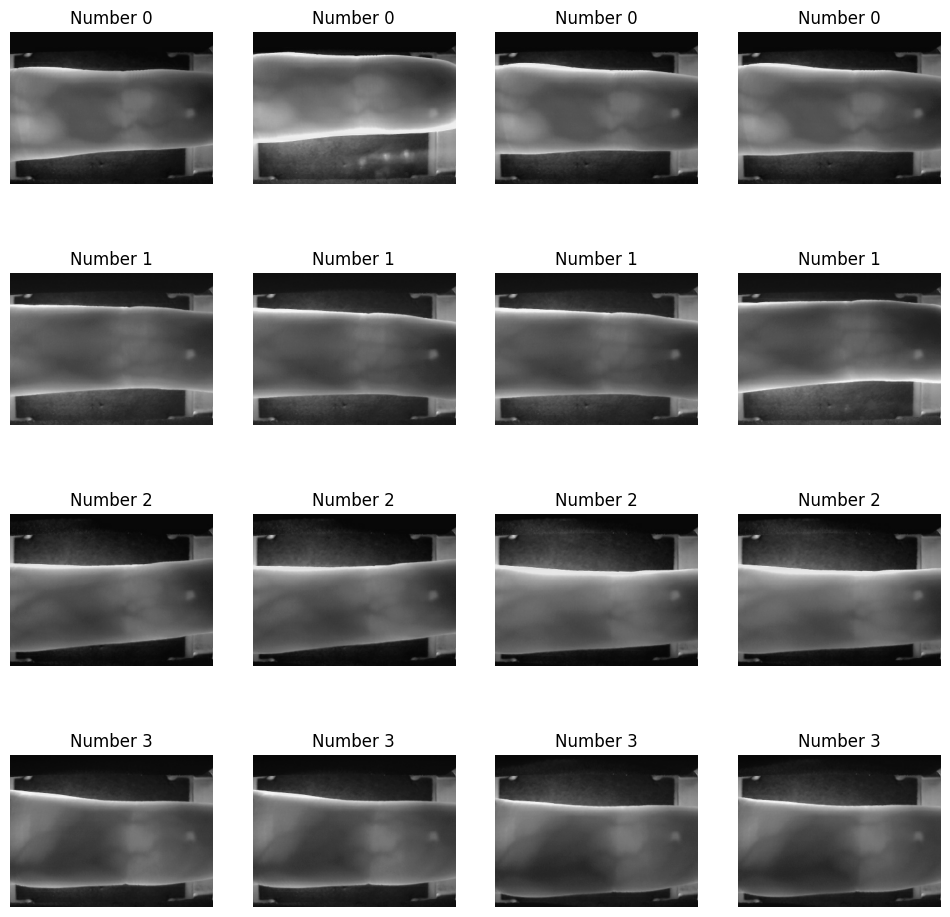

In [60]:
fig, axs = plt.subplots(4, 4, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(Y_train[i]))

# display the figure
plt.show()

## Preprocessing

### Reshape
Images stored as NumPy arrays are 2-dimensional arrays. However, the K-means clustering algorithm provided by scikit-learn ingests 1-dimensional arrays; as a result, we will need to reshape each image. (in other words, we need to **flatten** the data)

Clustering algorithms almost always use 1-dimensional data. For example, if you were clustering a set of X, Y coordinates, each point would be passed to the clustering algorithm as a 1-dimensional array with a length of two (example: [2,4] or [-1, 4]). If you were using 3-dimensional data, the array would have a length of 3 (example: [2, 4, 1] or [-1, 4, 5]).

MNIST contains images that are 28 by 28 pixels; as a result, they will have a length of 784 once we reshape them into a 1-dimensional array.

In [61]:
# Convert each image to 1d array (240x320x3 -> 230400x1)
X_train = X_train.reshape(len(X_train), -1)
print(X_train.shape)

(240, 230400)


### Normalization
Also, One approach to help training is **normalization**. In order to do this, we need to convert each pixel value into 0 to 1 range. The maximum value of pixel in grayscale is 255, so it can normalize it by dividing 255. Of course, its overall shape is same as before.

In [62]:
# Normalize the data to 0 - 1
X_train = X_train.astype(np.float32) / 255.

## Applying K-means Clustering
Since the size of the MNIST dataset is quite large, we will use the **mini-batch** implementation of k-means clustering (`MiniBatchKMeans`) provided by scikit-learn. This will dramatically reduce the amount of time it takes to fit the algorithm to the data.

Here, we just choose the `n_clusters` argument to the `n_digits`(the size of unique labels, in our case, 10), and set the default parameters in `MiniBatchKMeans`.

And as you know that, K-means clustering is one of the unsupervised learning. That means it doesn't require any label to train.

In [63]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_digits = len(np.unique(Y_train))
print(n_digits)

60


In [64]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """

    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key

    return predicted_labels

In [95]:
def bench_k_means(kmeans, name, data,labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    kmeans.fit(data)
    cluster_labels = infer_cluster_labels(kmeans, labels)
    X_clusters = kmeans.predict(data)
    predicted_labels = infer_data_labels(X_clusters, cluster_labels)
    fit_time = time() - t0
    results = [name, fit_time, kmeans.inertia_]
    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
        metrics.accuracy_score
    ]
    results += [m(labels, predicted_labels) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            predicted_labels,
            metric="euclidean",
            sample_size=300,
        )
    ]
    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return predicted_labels

In [87]:
# kmeans = KMeans(n_clusters=n_digits)
# kmeans.fit(X_train)
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tAcc\tsilhouette")
# 使用k-means++进行初始化。
kmeans = KMeans(init="k-means++", n_clusters=n_digits,n_init=1, random_state=0)
predicted_labels1=bench_k_means(kmeans=kmeans, name="k-means++",data=X_train,labels=Y_train)
centers1=kmeans.cluster_centers_
# 随机初始化。
kmeans = KMeans(init="random", n_clusters=n_digits, random_state=0,n_init=1)
predicted_labels2=bench_k_means(kmeans=kmeans, name="random", data=X_train, labels=Y_train)
centers2=kmeans.cluster_centers_
#基于PCA投影的初始化。该方法是确定性的，一次初始化就足够了。
pca = PCA(n_components=n_digits).fit(X_train)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
predicted_labels3=bench_k_means(kmeans=kmeans, name="PCA-based", data=X_train, labels=Y_train)
centers3=kmeans.cluster_centers_
print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	Acc	silhouette
k-means++	25.765s	84577	0.929	0.959	0.944	0.752	0.841	0.854	0.465
random   	2.173s	120100	0.894	0.958	0.925	0.651	0.799	0.771	0.390
PCA-based	6.012s	245155	0.674	0.944	0.786	0.206	0.585	0.454	0.234
__________________________________________________________________________________


We can find the labels of each input that is generated from K means model.

In [14]:
kmeans.labels_

array([ 6,  5,  6,  6, 43, 52, 52,  9, 59, 59, 10, 10, 55, 55, 58, 58, 55,
       55, 23, 23, 44, 44, 55, 55, 16, 17, 18, 19, 47, 47, 47, 55, 25, 24,
       24, 30, 33, 33, 33, 33, 35, 36, 37, 38, 39, 40, 41,  2, 43, 43, 52,
       52,  0,  0,  0, 44, 11, 11, 55, 55, 34, 34, 34, 23, 55, 55, 55, 23,
       52, 53, 54, 54, 56, 57, 51, 50, 49, 48, 48, 46, 45, 42, 29, 28, 27,
       22, 21, 20, 15, 14, 13, 12,  8,  7,  7,  7,  1,  1,  1,  1,  0,  0,
        0,  0, 31, 31, 31, 31, 44, 44, 44, 44,  0,  0,  0,  0,  0,  0,  0,
        0, 44, 44, 44, 44,  0,  0,  0,  0, 58, 58, 58, 58, 58, 58,  0,  0,
        0,  0,  0,  0, 44, 44, 44, 44,  1,  1,  1,  1,  1,  1,  1, 31, 31,
       31, 31, 31,  1,  1,  1,  1, 31, 31, 31, 31,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  4,  4,  1, 31,  1,  1,
        1,  1,  1,  1,  1,  4,  4,  1,  1,  1,  1,  1,  1, 31, 31, 31, 31,
        4,  4,  4,  4,  1,  1,  1,  1, 26, 26, 26, 26,  4,  4,  4,  4,  1,
        1,  1,  1, 32, 32

In [16]:
pca.components_
print((pca.components_).shape)

(60, 230400)


But these are not real label of each image, since the output of the `kmeans.labels_` is just group id for clustering. For example, 6 in `kmeans.labels_` has similar features with another 6 in `kmeans.labels_`. There is no more meaning from the label.

To match it with real label, we can tackle the follow things:

- Combine each images in the same group
- Check Frequency distribution of actual labels (using `np.bincount`)
- Find the Maximum frequent label (through `np.argmax`), and set the label.

As a result, some predicted label is mismatched, but most of case, the k-means model can correctly cluster of each group.

## Evaluating Clustering Algorithm
With the functions defined above, we can now determine the accuracy of our algorithms. Since we are using this clustering algorithm for classification, accuracy is ultimately the most important metric; however, there are other metrics out there that can be applied directly to the clusters themselves, regardless of the associated labels. Two of these metrics that we will use are **inertia** and **homogeneity**. (See the detailed description of [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html))

Furthermore, earlier we made the assumption that K = 10 was the appropriate number of clusters; however, this might not be the case. Let's fit the K-means clustering algorithm with several different values of K, than evaluate the performance using our metrics.

In [77]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertia
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Homogeneity Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    completeness=completeness_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    print("completeness score: {}".format(completeness))
    return inertia, homogeneity, completeness

In [78]:
from sklearn.metrics import accuracy_score

# clusters = [2,4,8,16,32,60,128]
clusters = [60]
iner_list = []
homo_list = []
acc_list = []
clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
]
for n_clusters in clusters:
    estimator = KMeans(init="k-means++", n_clusters=n_clusters,n_init='auto', random_state=0)
    estimator.fit(X_train)

    inertia, homo, = calc_metrics(estimator, X_train, Y_train)
    iner_list.append(inertia)
    homo_list.append(homo)

    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y_train)
    prediction = infer_data_labels(estimator.labels_, cluster_labels)

    acc = accuracy_score(Y_train, prediction)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

Number of Clusters: 60
Inertia: 84577.421875
Homogeneity score: 0.9313180780592772
completeness score: 0.9474658035740694


ValueError: ignored

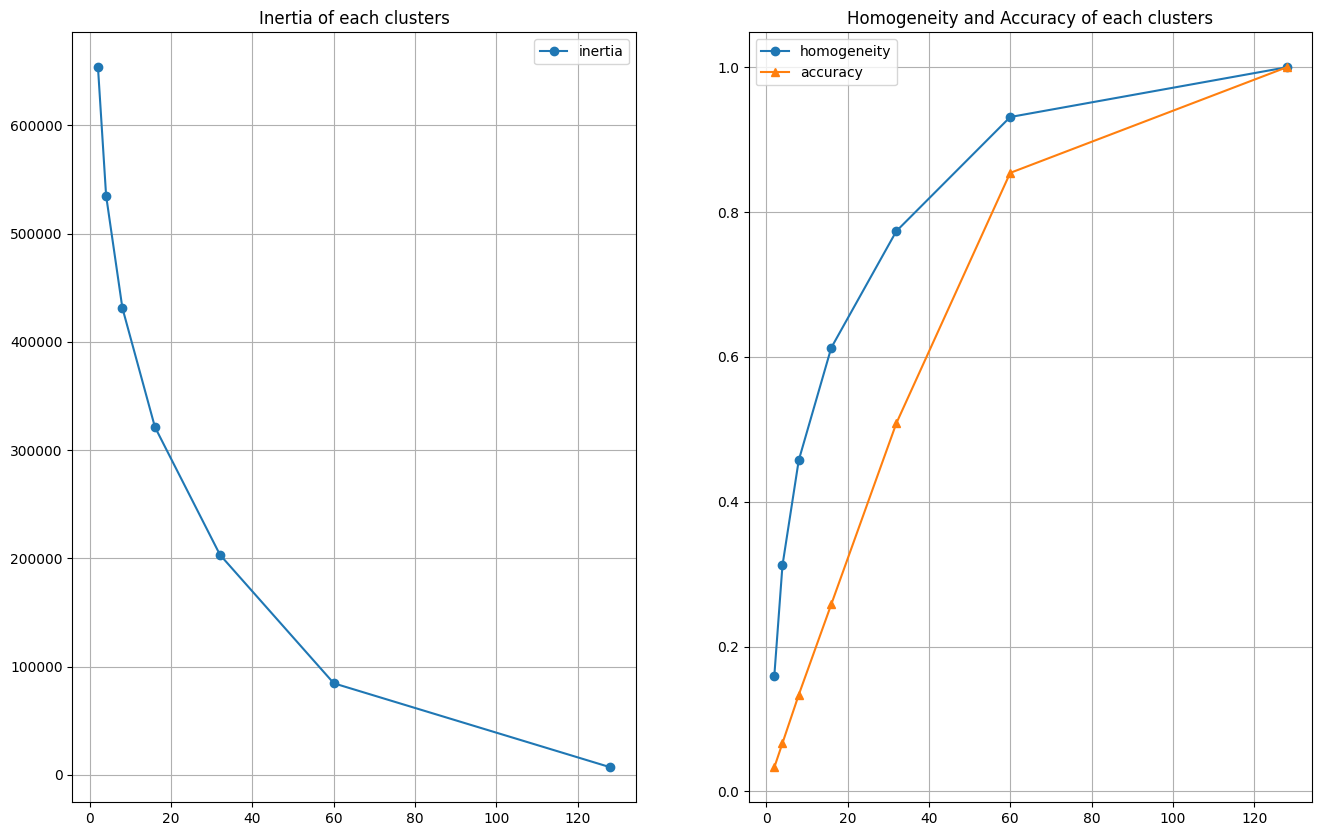

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
plt.show()

As a result, we found out that when the K value is increased, the accuracy and homogeneity is also increased. We can also check the performance on test dataset.

There we have MiniBatchKmeans Clustering model with almost 90% accuracy. One definite way to check the model performance is to visualize the real image.

For the convenience, we decrease the `n_clusters` to 36.

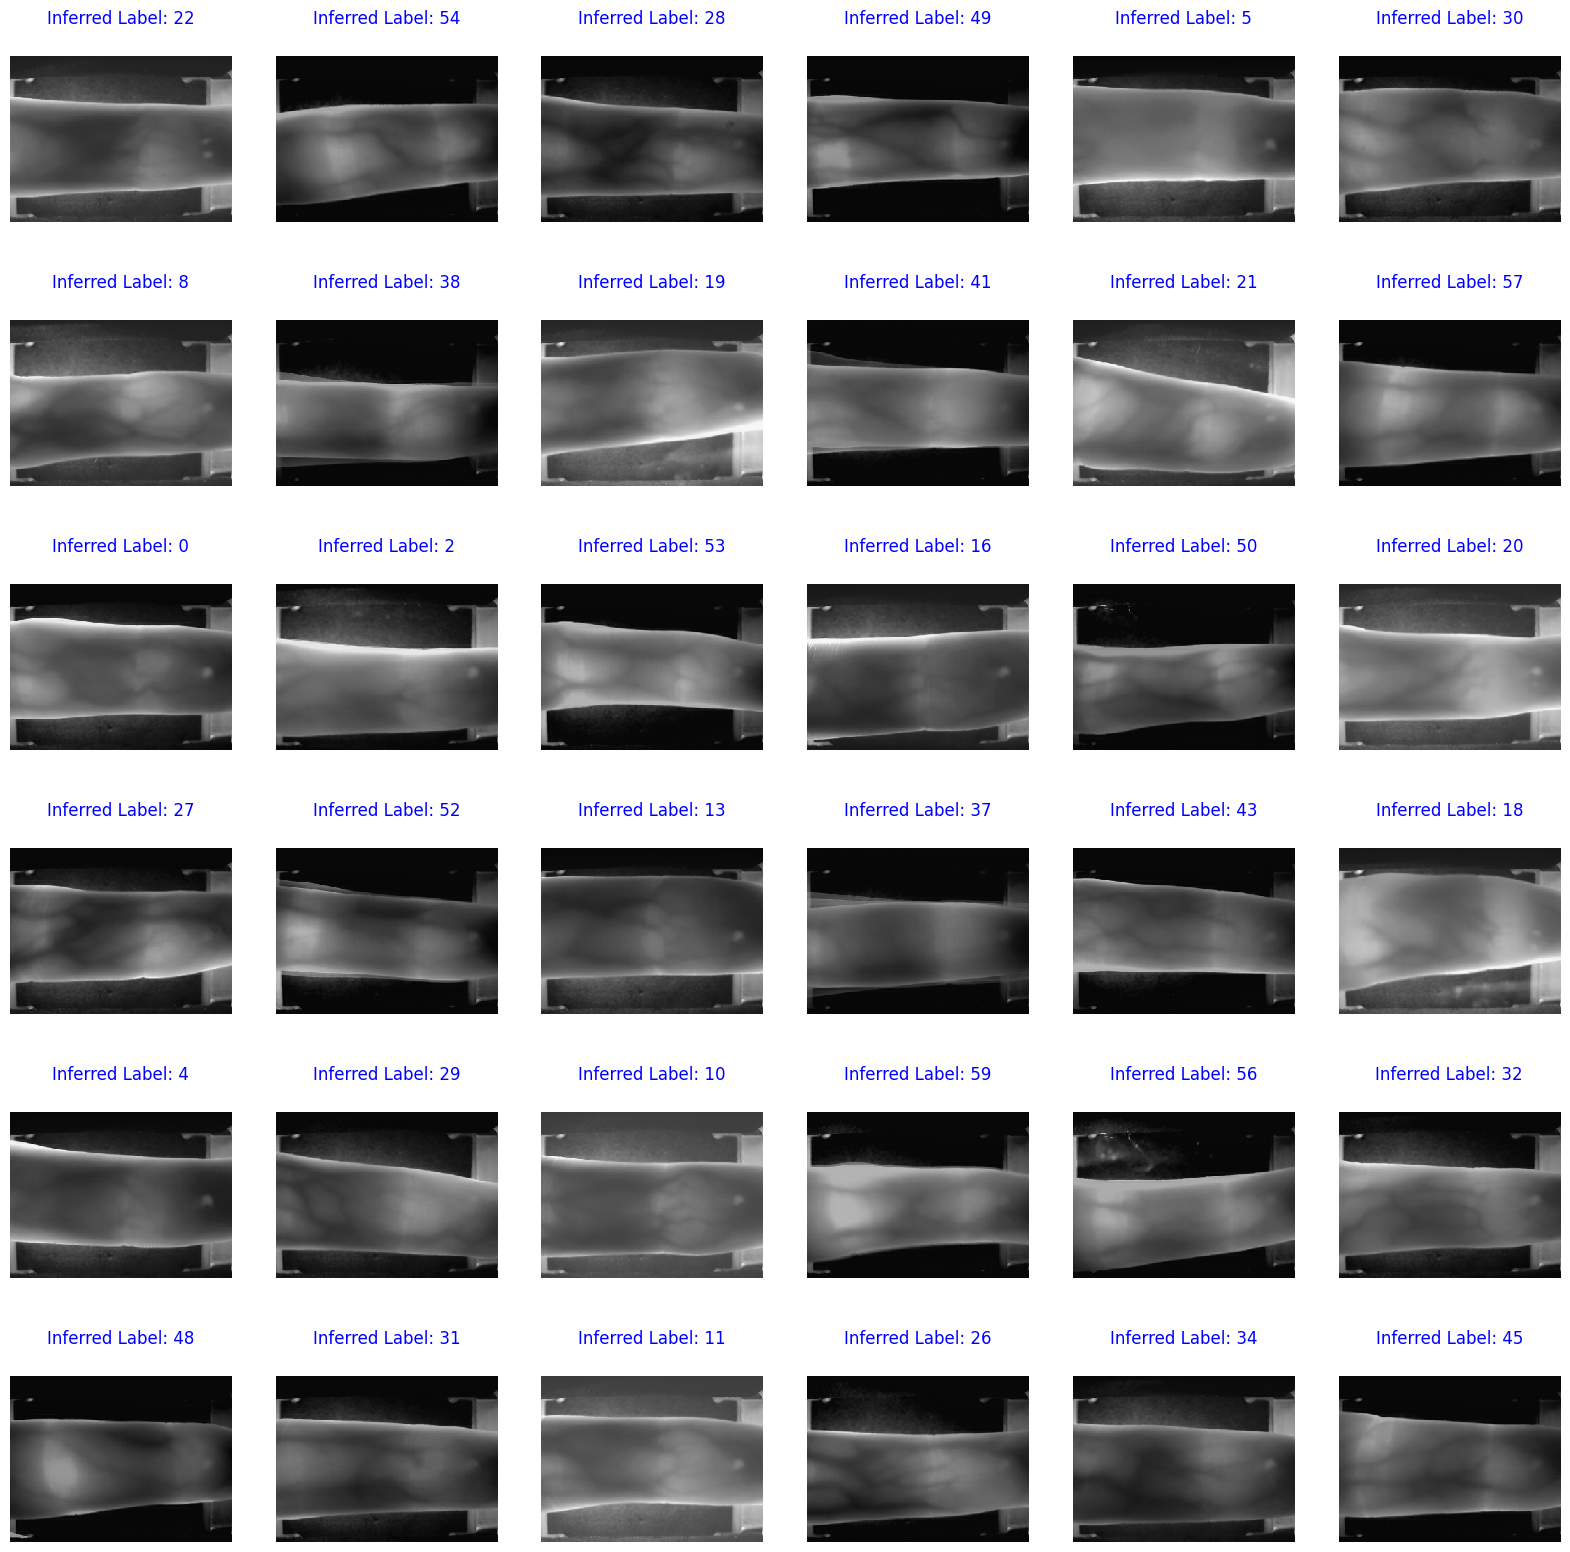

In [40]:
# Initialize and fit KMeans algorithm
kmeans = KMeans(init="k-means++", n_clusters=n_digits,n_init='auto', random_state=0)
kmeans.fit(X_test)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(60, 240, 320,3)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y_test)
prediction = infer_data_labels(kmeans.predict(X_test), cluster_labels)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):

    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key), color='blue')

    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')

# display the figure
plt.show()

## Summary
Through this post, we built the K means clustering model for MNIST digit classification. To do this, we applied preprocessing steps like reshape and normalization. And the model performance is changed in depends on n_clusters. After that, we can make MNIST classifier with almost 90%.
PCA allows to project the data from the original 64-dimensional space into a lower dimensional space. Subsequently, we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space.

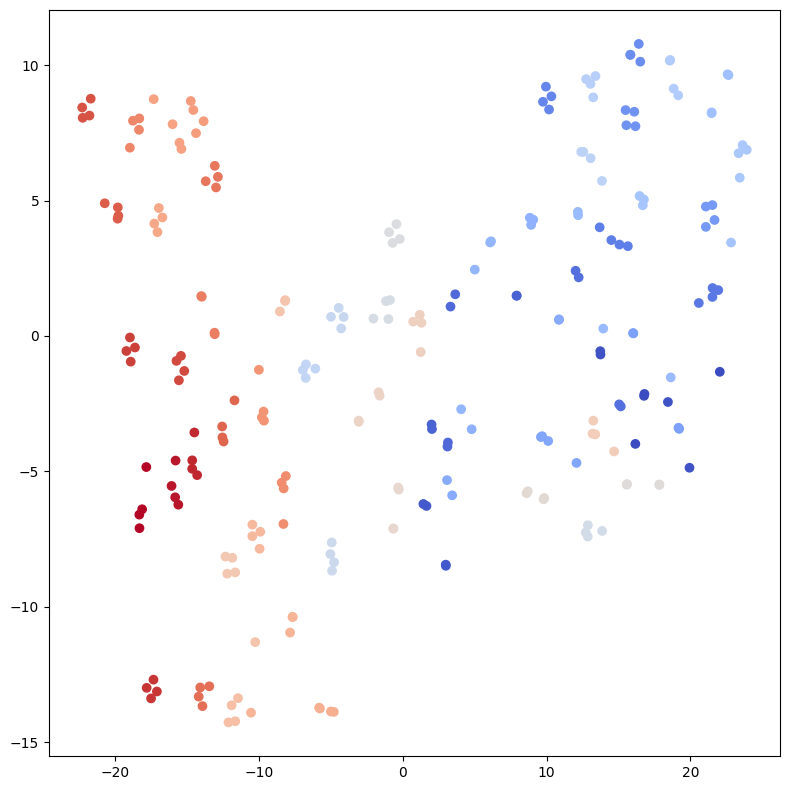

In [92]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
from random import random
word_embedding = X_train
# 将词向量中值最大的维度的下标作为该词向量的标签
label1 = Y_train
label2 = predicted_labels1
# 将词向量转化为2维向量
fea = TSNE(n_components=2).fit_transform(word_embedding)

pdf = PdfPages('word_embedding_scatter.pdf')
plt.figure(figsize=(8, 8))
plt.scatter(fea[:, 0], fea[:, 1], marker='o', c=label1, cmap='coolwarm')
# plt.scatter(
#     centers1[:, 0],
#     centers1[:, 1],
#     marker="x",
#     s=169,
#     linewidths=3,
#     color="b",
#     zorder=10,
# )
plt.tight_layout()
pdf.savefig()
plt.show()
pdf.close()

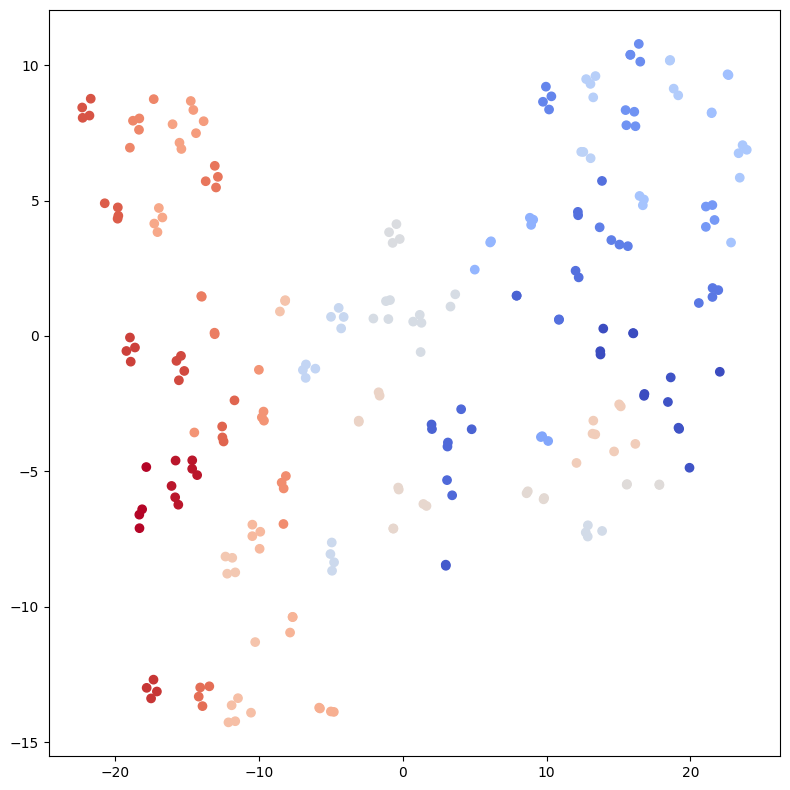

In [93]:
pdf = PdfPages('word_embedding_scatter.pdf')
plt.figure(figsize=(8, 8))
plt.scatter(fea[:, 0], fea[:, 1], marker='o', c=label2, cmap='coolwarm')
# plt.scatter(
#     centers1[:, 0],
#     centers1[:, 1],
#     marker="x",
#     s=169,
#     linewidths=3,
#     color="b",
#     zorder=10,
# )
plt.tight_layout()
pdf.savefig()
plt.show()
pdf.close()

In [96]:
# Convert each image to 1d array (240x320x3 -> 230400x1)
X_test = X_test.reshape(len(X_test), -1)
print(X_test.shape)
# Normalize the data to 0 - 1
X_test = X_test.astype(np.float32) / 255.
n_digits = len(np.unique(Y_test))
print(n_digits)
# kmeans = KMeans(n_clusters=n_digits)
# kmeans.fit(X_train)
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
# 使用k-means++进行初始化。
kmeans = KMeans(init="k-means++", n_clusters=n_digits,n_init='auto', random_state=0)
predicted_labels1=bench_k_means(kmeans=kmeans, name="k-means++",data=X_test,labels=Y_test)
# 随机初始化。
kmeans = KMeans(init="random", n_clusters=n_digits, random_state=0,n_init='auto')
predicted_labels2=bench_k_means(kmeans=kmeans, name="random", data=X_test, labels=Y_test)
#基于PCA投影的初始化。该方法是确定性的，一次初始化就足够了。
pca = PCA(n_components=n_digits).fit(X_test)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
predicted_labels3=bench_k_means(kmeans=kmeans, name="PCA-based", data=X_test, labels=Y_test)
print(82 * "_")

(120, 230400)
60
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	15.716s	0	0.988	0.994	0.991	0.935	0.949	0.975	0.699
random   	9.858s	0	0.955	0.988	0.971	0.760	0.848	0.892	0.627
PCA-based	2.487s	2	0.735	1.000	0.847	0.173	0.539	0.567	0.372
__________________________________________________________________________________


In [ ]:
import glob
def preprocessing():
  cnt=0
  fingers=glob.glob("/content/drive/MyDrive/SDUMLA/*/*/*.bmp")
  if not os.path.exists("/content/drive/MyDrive/SDUMLA_1/"):
    os.mkdir("/content/drive/MyDrive/SDUMLA_1/")

  for finger in fingers:
    # print(finger.split("/"))
    if not os.path.exists(os.path.join("/content/drive/MyDrive/SDUMLA_1/",finger.split("/")[5])):
      os.mkdir(os.path.join("/content/drive/MyDrive/SDUMLA_1/",finger.split("/")[5]))
    if not os.path.exists(os.path.join("/content/drive/MyDrive/SDUMLA_1/",finger.split("/")[5],finger.split("/")[6])):
      os.mkdir(os.path.join("/content/drive/MyDrive/SDUMLA_1/",finger.split("/")[5],finger.split("/")[6]))
    img1=cv2.imread(finger)
    #subsampled to 336 × 190 pixels in order to guarantee uniformity

    #for the databases where the images show a ratio between
    #number of rows and columns different from the target one,
    #marginal background parts are removed by selecting a central
    #area of the image.
    img1=img1[25:215,0:320]
    img2=cv2.resize(img1, (336, img1.shape[0]), interpolation=cv2.INTER_AREA)
    height,width,_=img2.shape
    img2gray=cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    oimg2gray=img2gray.copy()

    # cv2.imshow('image1', oimg2gray)
    #The masking value is calculated in the Y direction for each X position,
    #and the position at which the masking value becomes maximal is
    #determined as the boundary position between the finger and the
    #background in the Y direction.

    w=width#遮罩宽度
    h1=66#上遮罩高度
    h2=20#下遮罩高度
    #Masks for detection of upper region of finger
    mup = np.ones((h1,w))
    for y in range(int(h1/2)):
      for x in range(w):
       mup[y][x]=-1

    #Masks for detection of lower region of finger
    mdown = np.ones((h2,w))
    for y in range(int(h2/2)):
      for x in range(w):
       mdown[h2-y-1][x]=-1

    for i in range(h1):
      for j in range(w):
        mup[i][j]=img2gray[i][j]*mup[i][j]
    for i in range(h2):
      for j in range(w):
          mdown[h2-i-1][j]=img2gray[height-i-1][j]*mdown[h2-i-1][j]
    yup=[]
    ydown=[]
    for j in range(w):
      maxid=0
      maxv=mup[maxid][j]
      for i in range(h1):
        if maxv<=mup[i][j]:
          maxv=mup[i][j]
          maxid=i
      yup.append(maxid)

      maxid=0
      maxv=mdown[h2-maxid-1][j]
      for i in range(h2):
        if maxv<=mdown[h2-i-1][j]:
          maxv=mdown[h2-i-1][j]
          maxid=height-i-1
      ydown.append(maxid)

    yup_pred=pfit(width,yup)
    ydown_pred=pfit(width,ydown)
    for j in range(w):
      for i in range(height):
        if i<yup_pred[j]:
          img2gray[i][j]=0
        else:
          img2gray[i][j]=255
      for i in range(height):
        if i>ydown_pred[j]:
          img2gray[i][j]=0

    # cv2.imshow('image2', img2gray)

    for i in range(height):
      for j in range(width):
        if img2gray[i][j]==0:
          oimg2gray[i][j]=0
        else:
          oimg2gray[i][j]=oimg2gray[i][j]

    # cv2.imshow('image3', oimg2gray)

    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    img_dst_clahe = clahe.apply(oimg2gray)
    #cv2.imshow('image2', img_dst_clahe)
    # cv2.imshow('image4', img_dst_clahe)
    # cv2.waitKey(0)
    cv2.imwrite(os.path.join("/content/drive/MyDrive/SDUMLA_1/",finger.split("/")[5],finger.split("/")[6],finger.split("/")[7]),img_dst_clahe)
    # break
    # continue
    # img=cv2.resize(img_dst_clahe, (153,65), interpolation=cv2.INTER_AREA)
    #cv2.imshow('img', img)

    #cv2.imwrite(trainfile, img)



def pfit(x,y):
    x = np.arange(1, x+1, 1)
    y = np.array(y)
    z1 = np.polyfit(x, y, 2)              # 曲线拟合，返回值为多项式的各项系数
    p1 = np.poly1d(z1)                    # 返回值为多项式的表达式，也就是函数式子
    y_pred=[]
    for item in x:
      y_pred.append(int(p1(item)+0.5))
    return y_pred

preprocessing()

In [114]:
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
basepath="/content/drive/MyDrive/SDUMLA_1"
label=0
for i in tqdm(range(1,11)):
  path1=os.path.join(basepath,"%03d"%i)
  for j in ['left','right']:
    path2=os.path.join(path1,j)
    for k in ['index','middle','ring']:
      # 读取训练数据集
      for m in range(1,5):
        path3=os.path.join(path2,"%s_%d.bmp"%(k,m))
        X_train.append(cv2.imread(path3))
        Y_train.append(label)
      # 读取测试数据集
      for m in range(5,7):
        path3=os.path.join(path2,"%s_%d.bmp"%(k,m))
        X_test.append(cv2.imread(path3))
        Y_test.append(label)
      label+=1
X_train=np.array(X_train)
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)
# Print shape of dataset
print("Training: {}".format(X_train.shape))
print("Test: {}".format(X_test.shape))

100%|██████████| 10/10 [00:01<00:00,  6.65it/s]

Training: (240, 190, 336, 3)
Test: (120, 190, 336, 3)


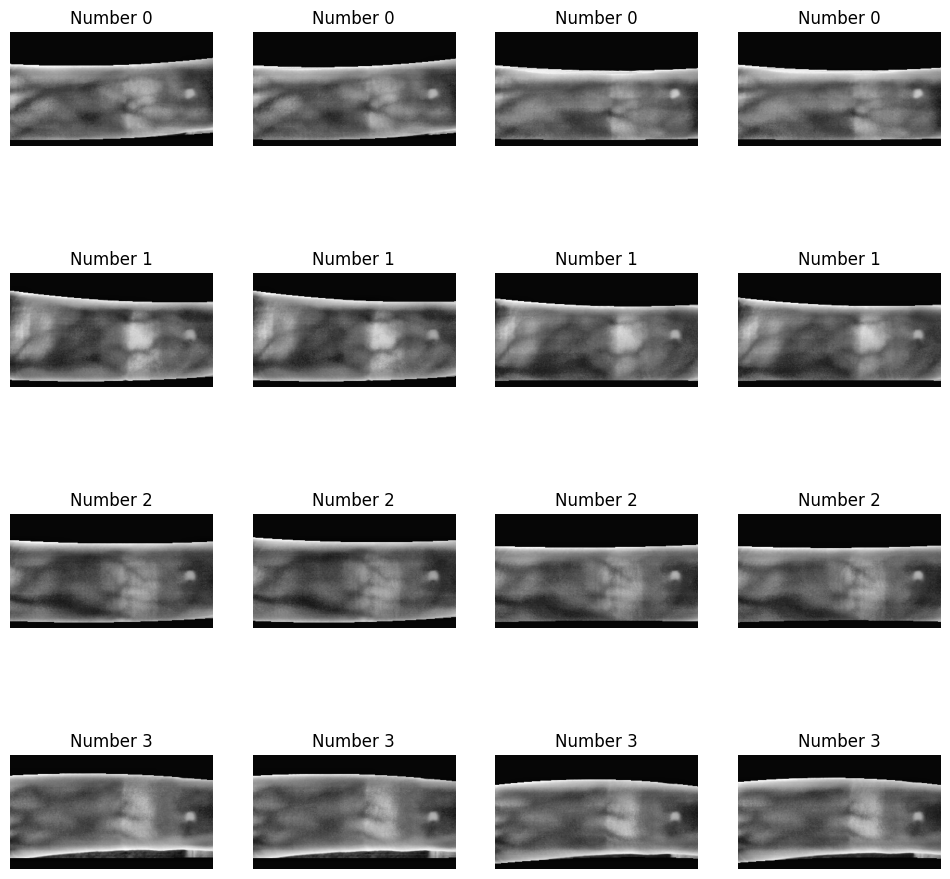

In [31]:
fig, axs = plt.subplots(4, 4, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i+8])
    ax.axis('off')
    ax.set_title('Number {}'.format(Y_train[i]))

# display the figure
plt.show()

In [115]:
# Convert each image to 1d array (240x320x3 -> 230400x1)
X_train = X_train.reshape(len(X_train), -1)
print(X_train.shape)

(240, 191520)


In [116]:
# Normalize the data to 0 - 1
X_train = X_train.astype(np.float32) / 255.

In [117]:
n_digits = len(np.unique(Y_train))
print(n_digits)

60


In [118]:
# kmeans = KMeans(n_clusters=n_digits)
# kmeans.fit(X_train)
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
# 使用k-means++进行初始化。
kmeans = KMeans(init="k-means++", n_clusters=n_digits,n_init='auto', random_state=0)
predicted_labels1=bench_k_means(kmeans=kmeans, name="k-means++",data=X_train,labels=Y_train)
# 随机初始化。
kmeans = KMeans(init="random", n_clusters=n_digits, random_state=0,n_init='auto')
predicted_labels2=bench_k_means(kmeans=kmeans, name="random", data=X_train, labels=Y_train)
#基于PCA投影的初始化。该方法是确定性的，一次初始化就足够了。
pca = PCA(n_components=n_digits).fit(X_train)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
predicted_labels3=bench_k_means(kmeans=kmeans, name="PCA-based", data=X_train, labels=Y_train)
print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	23.262s	211176	0.907	0.939	0.923	0.682	0.782	0.821	0.381
random   	19.934s	271723	0.861	0.931	0.895	0.564	0.723	0.725	0.297
PCA-based	7.418s	487368	0.651	0.931	0.766	0.179	0.554	0.454	0.183
__________________________________________________________________________________


In [119]:
# Convert each image to 1d array (240x320x3 -> 230400x1)
X_test = X_test.reshape(len(X_test), -1)
print(X_test.shape)
# Normalize the data to 0 - 1
X_test = X_test.astype(np.float32) / 255.
n_digits = len(np.unique(Y_test))
print(n_digits)
# kmeans = KMeans(n_clusters=n_digits)
# kmeans.fit(X_train)
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
# 使用k-means++进行初始化。
kmeans = KMeans(init="k-means++", n_clusters=n_digits,n_init='auto', random_state=0)
predicted_labels1=bench_k_means(kmeans=kmeans, name="k-means++",data=X_test,labels=Y_test)
# 随机初始化。
kmeans = KMeans(init="random", n_clusters=n_digits, random_state=0,n_init='auto')
predicted_labels2=bench_k_means(kmeans=kmeans, name="random", data=X_test, labels=Y_test)
#基于PCA投影的初始化。该方法是确定性的，一次初始化就足够了。
pca = PCA(n_components=n_digits).fit(X_test)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
predicted_labels3=bench_k_means(kmeans=kmeans, name="PCA-based", data=X_test, labels=Y_test)
print(82 * "_")

(120, 191520)
60
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	15.985s	30135	0.979	0.991	0.985	0.883	0.915	0.950	0.597
random   	9.648s	61604	0.948	0.988	0.968	0.754	0.832	0.867	0.524
PCA-based	2.383s	183747	0.765	0.982	0.860	0.208	0.538	0.608	0.371
__________________________________________________________________________________


In [37]:
import glob
def preprocessing():
  cnt=0
  fingers=glob.glob("/content/drive/MyDrive/SDUMLA/*/*/*.bmp")
  if not os.path.exists("/content/drive/MyDrive/SDUMLA_2/"):
    os.mkdir("/content/drive/MyDrive/SDUMLA_2/")

  for finger in tqdm(fingers):
    # print(finger.split("/"))
    if not os.path.exists(os.path.join("/content/drive/MyDrive/SDUMLA_2/",finger.split("/")[5])):
      os.mkdir(os.path.join("/content/drive/MyDrive/SDUMLA_2/",finger.split("/")[5]))
    if not os.path.exists(os.path.join("/content/drive/MyDrive/SDUMLA_2/",finger.split("/")[5],finger.split("/")[6])):
      os.mkdir(os.path.join("/content/drive/MyDrive/SDUMLA_2/",finger.split("/")[5],finger.split("/")[6]))
    img1=cv2.imread(finger)
    #subsampled to 336 × 190 pixels in order to guarantee uniformity

    #for the databases where the images show a ratio between
    #number of rows and columns different from the target one,
    #marginal background parts are removed by selecting a central
    #area of the image.
    img1=img1[25:215,0:320]
    img2=cv2.resize(img1, (336, img1.shape[0]), interpolation=cv2.INTER_AREA)
    height,width,_=img2.shape
    img2gray=cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    oimg2gray=img2gray.copy()

    # cv2.imshow('image1', oimg2gray)
    #The masking value is calculated in the Y direction for each X position,
    #and the position at which the masking value becomes maximal is
    #determined as the boundary position between the finger and the
    #background in the Y direction.

    w=width#遮罩宽度
    h1=66#上遮罩高度
    h2=20#下遮罩高度
    #Masks for detection of upper region of finger
    mup = np.ones((h1,w))
    for y in range(int(h1/2)):
      for x in range(w):
       mup[y][x]=-1

    #Masks for detection of lower region of finger
    mdown = np.ones((h2,w))
    for y in range(int(h2/2)):
      for x in range(w):
       mdown[h2-y-1][x]=-1

    for i in range(h1):
      for j in range(w):
        mup[i][j]=img2gray[i][j]*mup[i][j]
    for i in range(h2):
      for j in range(w):
          mdown[h2-i-1][j]=img2gray[height-i-1][j]*mdown[h2-i-1][j]
    yup=[]
    ydown=[]
    for j in range(w):
      maxid=0
      maxv=mup[maxid][j]
      for i in range(h1):
        if maxv<=mup[i][j]:
          maxv=mup[i][j]
          maxid=i
      yup.append(maxid)

      maxid=0
      maxv=mdown[h2-maxid-1][j]
      for i in range(h2):
        if maxv<=mdown[h2-i-1][j]:
          maxv=mdown[h2-i-1][j]
          maxid=height-i-1
      ydown.append(maxid)

    yup_pred=yup
    ydown_pred=ydown
    for j in range(w):
      for i in range(height):
        if i<yup_pred[j]:
          img2gray[i][j]=0
        else:
          img2gray[i][j]=255
      for i in range(height):
        if i>ydown_pred[j]:
          img2gray[i][j]=0

    # cv2.imshow('image2', img2gray)

    for i in range(height):
      for j in range(width):
        if img2gray[i][j]==0:
          oimg2gray[i][j]=0
        else:
          oimg2gray[i][j]=oimg2gray[i][j]

    # cv2.imshow('image3', oimg2gray)

    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    img_dst_clahe = clahe.apply(oimg2gray)
    #cv2.imshow('image2', img_dst_clahe)
    # cv2.imshow('image4', img_dst_clahe)
    # cv2.waitKey(0)
    cv2.imwrite(os.path.join("/content/drive/MyDrive/SDUMLA_2/",finger.split("/")[5],finger.split("/")[6],finger.split("/")[7]),img_dst_clahe)

    # continue
    # img=cv2.resize(img_dst_clahe, (153,65), interpolation=cv2.INTER_AREA)
    #cv2.imshow('img', img)

    #cv2.imwrite(trainfile, img)

preprocessing()

100%|██████████| 360/360 [01:41<00:00,  3.55it/s]


In [103]:
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
basepath="/content/drive/MyDrive/SDUMLA_2"
label=0
for i in tqdm(range(1,11)):
  path1=os.path.join(basepath,"%03d"%i)
  for j in ['left','right']:
    path2=os.path.join(path1,j)
    for k in ['index','middle','ring']:
      # 读取训练数据集
      for m in range(1,5):
        path3=os.path.join(path2,"%s_%d.bmp"%(k,m))
        X_train.append(cv2.imread(path3))
        Y_train.append(label)
      # 读取测试数据集
      for m in range(5,7):
        path3=os.path.join(path2,"%s_%d.bmp"%(k,m))
        X_test.append(cv2.imread(path3))
        Y_test.append(label)
      label+=1
X_train=np.array(X_train)
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)
# Print shape of dataset
print("Training: {}".format(X_train.shape))
print("Test: {}".format(X_test.shape))

100%|██████████| 10/10 [00:01<00:00,  7.30it/s]

Training: (240, 190, 336, 3)
Test: (120, 190, 336, 3)


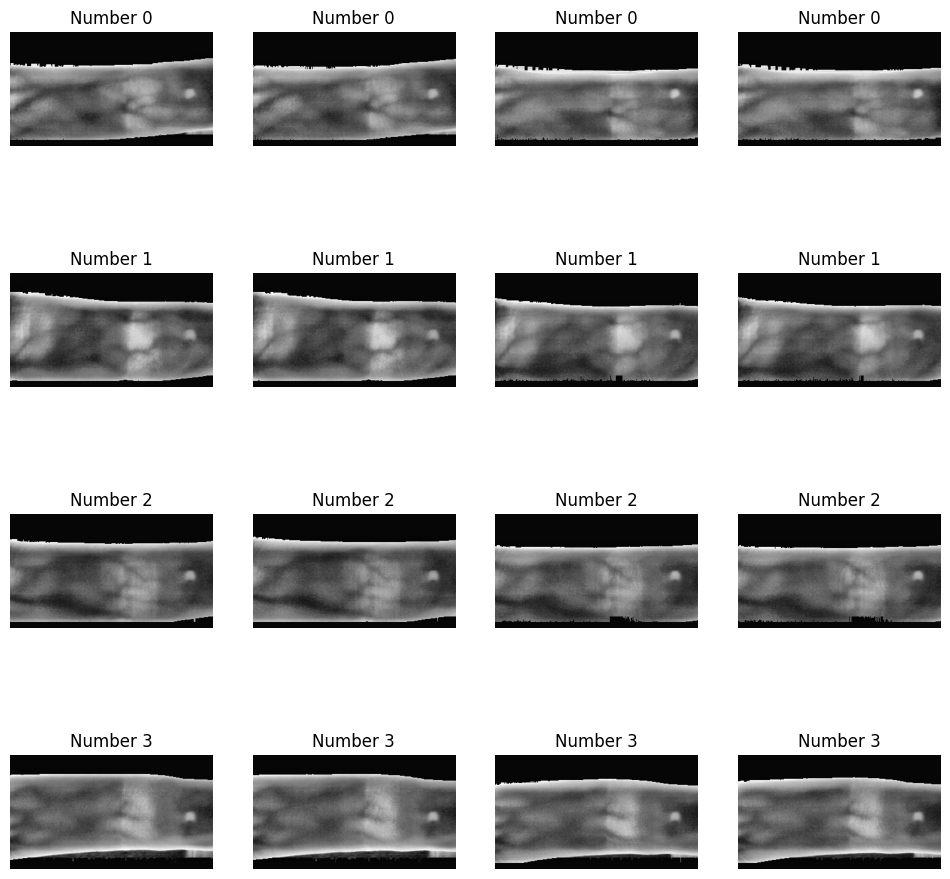

In [41]:
fig, axs = plt.subplots(4, 4, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i+8])
    ax.axis('off')
    ax.set_title('Number {}'.format(Y_train[i]))

# display the figure
plt.show()

In [105]:
# Convert each image to 1d array (240x320x3 -> 230400x1)
X_train = X_train.reshape(len(X_train), -1)
print(X_train.shape)

(240, 191520)


In [106]:
# Normalize the data to 0 - 1
X_train = X_train.astype(np.float32) / 255.

In [107]:
n_digits = len(np.unique(Y_train))
print(n_digits)

60


In [108]:
# kmeans = KMeans(n_clusters=n_digits)
# kmeans.fit(X_train)
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
# 使用k-means++进行初始化。
kmeans = KMeans(init="k-means++", n_clusters=n_digits,n_init='auto', random_state=0)
predicted_labels1=bench_k_means(kmeans=kmeans, name="k-means++",data=X_train,labels=Y_train)
# 随机初始化。
kmeans = KMeans(init="random", n_clusters=n_digits, random_state=0,n_init='auto')
predicted_labels2=bench_k_means(kmeans=kmeans, name="random", data=X_train, labels=Y_train)
#基于PCA投影的初始化。该方法是确定性的，一次初始化就足够了。
pca = PCA(n_components=n_digits).fit(X_train)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
predicted_labels3=bench_k_means(kmeans=kmeans, name="PCA-based", data=X_train, labels=Y_train)
print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	31.948s	228508	0.900	0.926	0.913	0.643	0.751	0.808	0.370
random   	16.710s	282478	0.867	0.933	0.899	0.568	0.731	0.729	0.292
PCA-based	4.280s	494027	0.659	0.920	0.768	0.200	0.550	0.446	0.178
__________________________________________________________________________________


In [109]:
# Convert each image to 1d array (240x320x3 -> 230400x1)
X_test = X_test.reshape(len(X_test), -1)
print(X_test.shape)
# Normalize the data to 0 - 1
X_test = X_test.astype(np.float32) / 255.
n_digits = len(np.unique(Y_test))
print(n_digits)

(120, 191520)
60


In [113]:
# kmeans = KMeans(n_clusters=n_digits)
# kmeans.fit(X_train)
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
# 使用k-means++进行初始化。
kmeans = KMeans(init="k-means++", n_clusters=n_digits,n_init=1, random_state=0)
predicted_labels1=bench_k_means(kmeans=kmeans, name="k-means++",data=X_test,labels=Y_test)
# 随机初始化。
kmeans = KMeans(init="random", n_clusters=n_digits, random_state=0,n_init=1)
predicted_labels2=bench_k_means(kmeans=kmeans, name="random", data=X_test, labels=Y_test)
#基于PCA投影的初始化。该方法是确定性的，一次初始化就足够了。
pca = PCA(n_components=n_digits).fit(X_test)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
predicted_labels3=bench_k_means(kmeans=kmeans, name="PCA-based", data=X_test, labels=Y_test)
print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	14.362s	36306	0.983	0.991	0.987	0.897	0.925	0.958	0.568
random   	1.202s	80546	0.923	0.985	0.953	0.636	0.769	0.817	0.487
PCA-based	2.738s	205658	0.721	0.988	0.834	0.125	0.499	0.592	0.329
__________________________________________________________________________________
